In [1]:
from griblib import ECMWF
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': -70.0, 'max': 10.0}
wind_lim = {'min': 20.0, 'max': 100.0}

# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
#'range-azimuth'
path_params['start'] = dict(lat=33.9621, lon=35.5635)
path_params['end'] = dict(lat=48.846135, lon=13.717930, name='I26DE')
#path_params['end'] = dict(lat=35.805200, lon=9.322900, name='I48TN')
#path_params['range'] = 1700.0e3
#path_params['azimuth'] = 26.0
dr = 10.0e3

In [5]:
#fid_grib = 'data/beirut_era5_20200804_17.grib'
#model_type = 'ERA5'
fid_grib = 'data/beirut_hres_20200804_17.grib'
model_type = 'OPER'
fid_grib_z = 'data/beirut_hres_20200804_18.grib'

In [6]:
my_atmos = ECMWF()
my_atmos.cycle = '-{}'.format(model_type)

In [7]:
# ds = my_atmos.read_grib(fid_grib)

# request = [
#     {'level_type': 'hybrid'}
# ]
request = [
    {'level_type': 'hybrid', 'var_list': ['z', 'lnsp', 't', 'u', 'v', 'w', 'q']}
]

ds = my_atmos.read_grib(fid_grib, request, compat='override')

# Convert lnsp field to surface pressure (sp) and add to dataset
sp = my_atmos.convert_lnsp_to_sp(ds.lnsp)
ds = xr.merge([sp.to_dataset(), ds])
ds = ds.drop(['lnsp'])

********************************************************************************
Reading ECMWF cy-OPER GRIB file [ data/beirut_hres_20200804_17.grib ]

Reading GRIB PV coefficients
Reading z on hybrid level
 - **ERROR**: variable z not found. Skipping...
Reading lnsp on hybrid level
Reading t on hybrid level
Reading u on hybrid level
Reading v on hybrid level
Reading w on hybrid level
Reading q on hybrid level


### Add geopotential to dataset (in case of Forecast file)

In [8]:
dsz = my_atmos.read_grib(fid_grib_z, request = [{'level_type': 'hybrid', 'var_list': 'z'}])
ds = xr.merge([ds, dsz], compat='override')

********************************************************************************
Reading ECMWF cy-OPER GRIB file [ data/beirut_hres_20200804_18.grib ]

Reading GRIB PV coefficients
Reading z on hybrid level


In [9]:
ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 350, longitude: 401)
Coordinates:
    time        datetime64[ns] 2020-08-04T12:00:00
    step        timedelta64[ns] 05:00:00
  * latitude    (latitude) float64 59.9 59.8 59.7 59.6 ... 25.3 25.2 25.1 25.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 0.4 ... 39.7 39.8 39.9 40.0
    valid_time  datetime64[ns] 2020-08-04T17:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137
Data variables:
    sp          (latitude, longitude) float32 1.001e+05 1.001e+05 ... 8.936e+04
    t           (hybrid, latitude, longitude) float32 ...
    u           (hybrid, latitude, longitude) float32 ...
    v           (hybrid, latitude, longitude) float32 ...
    w           (hybrid, latitude, longitude) float32 ...
    q           (hybrid, latitude, longitude) float32 ...
    z           (latitude, longitude) float32 ...

In [10]:
# t_fcst = (ds.valid_time).dt.strftime('%Y%m%d-%H').values
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

(t_fcst, title_str, fid_prefix) = plot_prefix(my_atmos, ds)

In [11]:
ds_gcp = my_atmos.extract_gcp_slice(ds, path_params, dr=dr)

In [12]:
ds_gcp

<xarray.Dataset>
Dimensions:     (distance: 246, hybrid: 137)
Coordinates:
    time        datetime64[ns] 2020-08-04T12:00:00
    step        timedelta64[ns] 05:00:00
    valid_time  datetime64[ns] 2020-08-04T17:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137
    longitude   (distance) float64 35.56 35.49 35.42 35.35 ... 13.94 13.83 13.72
    latitude    (distance) float64 33.96 34.03 34.1 34.17 ... 48.74 48.8 48.85
  * distance    (distance) float64 0.0 9.989e+03 ... 2.437e+06 2.447e+06
    azimuth     (distance) float64 -40.91 -40.95 -40.99 ... -55.37 -55.45 -55.53
Data variables:
    sp          (distance) float64 9.925e+04 1.011e+05 ... 9.184e+04 9.183e+04
    t           (hybrid, distance) float64 201.0 201.0 200.9 ... 284.7 284.7
    u           (hybrid, distance) float64 5.824 5.863 5.895 ... 0.1349 0.1355
    v           (hybrid, distance) float64 -5.74 -5.698 -5.655 ... -1.694 -1.488
    w           (hybrid, distance) float64 -3.866e-06 -4.232e-06 ... 0.08841
    q           (hybrid, distance) float64 2.398e-06 2.405e-06 ... 0.007122
    z           (distance) float64 1.189e+03 -604.7 ... 8.423e+03 8.456e+03

In [13]:
# Temperature (in degrees Celcius)
temperature = ds_gcp['t'].squeeze() - 273.15

temperature.attrs= {'long_name': 'temperature',
                    'units' : 'deg C',
                    'standard_name': 'air_temperature'}

# Wind speed
windspeed = np.sqrt(ds_gcp.u**2+ds_gcp.v**2).squeeze()
#windspeed = windspeed.where(windspeed > 0.985*wind_lim['min'])
windspeed.attrs= {'long_name': 'wind speed',
                    'units' : 'm/s',
                    'standard_name': 'wind_speed'}

In [14]:
lons = ds_gcp.longitude.values
lats = ds_gcp.latitude.values
coord_str = '({slo:.1f}E,{sla:.1f}N) > ({elo:.1f}E,{ela:.1f}N)'.format(
    slo=lons[0], sla=lats[0], elo=lons[-1], ela=lats[-1])
title_str = '{model}{cycle} fcst {time} UT - gcp {coords}'.format(
    model=my_atmos.model, cycle=my_atmos.cycle, time=t_fcst, coords=coord_str)


fid_prefix = '{model}{cycle}_{time}'.format(model=my_atmos.model, 
                                            cycle=my_atmos.cycle, 
                                            time=t_fcst)

In [15]:
# import matplotlib.colors as colors
# n_plots = 3

# fig, ax = plt.subplots(n_plots, 1, sharex=True, figsize=(8,8))
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.15, hspace=0.15)

# temperature.plot.imshow(cmap='Spectral_r',
#                      ax=ax[0],
#                      vmin=temp_lim['min'],
#                      vmax=temp_lim['max'],
#                      origin='upper',
#                      interpolation='bilinear')

# windspeed.plot.imshow(cmap='inferno_r', 
#                       ax=ax[1],
#                       vmin=wind_lim['min'],
#                       vmax=wind_lim['max'],
#                       origin='upper',
#                       interpolation='bilinear')

# ds_gcp['w'].plot.imshow(cmap='RdBu',
#                                   ax=ax[2],
#                                   vmin=-0.2,
#                                   vmax=0.2,
#                                   origin='upper',
#                                   interpolation='bilinear')

# for i in range(0,n_plots):
#     ax[i].set_title('')
#     ax[i].set_xlabel('')
    
# lons = ds_gcp.longitude.values
# lats = ds_gcp.latitude.values
# coord_str = '({slo:.1f}E,{sla:.1f}N) > ({elo:.1f}E,{ela:.1f}N)'.format(
#     slo=lons[0], sla=lats[0], elo=lons[-1], ela=lats[-1])
# title_str = '{model} fcst {time} UT - gcp {coords}'.format(
#     model=my_atmos.model, time=t_fcst, coords=coord_str)
# ax[0].set_title(title_str)

# ax[2].set_xlabel('Distance [m]')

In [16]:
# compute pressure, geopotential and geometric altitudes on model levels
(z, pres) = my_atmos.compute_altitude_pressure(t=ds_gcp.t,
                                               q=ds_gcp.q,
                                               ps=ds_gcp.sp,
                                               z0=ds_gcp.z)
dens = my_atmos.compute_density(pres, ds_gcp.t)

ds_gcp = ds_gcp.drop(['z'])
ds_gcp = xr.merge([z.to_dataset(), pres.to_dataset(), dens.to_dataset(), ds_gcp])

In [17]:
(cT, wa, wc, ce) = my_atmos.infrasound_propagation_conditions(t=ds_gcp.t,
                                                              u=ds_gcp.u,
                                                              v=ds_gcp.v,
                                                              azimuth=ds_gcp.azimuth)
c0 = ce.sel(hybrid=len(ds.hybrid))
cr = my_atmos.effective_sound_speed_ratio(ce, c0)

ds_gcp = xr.merge([cT.to_dataset(),
                   wa.to_dataset(),
                   wc.to_dataset(),
                   ce.to_dataset(),
                   cr.to_dataset(),
                   ds_gcp],
                   compat='override')

In [18]:
ds_gcp

<xarray.Dataset>
Dimensions:     (distance: 246, hybrid: 137)
Coordinates:
    time        datetime64[ns] 2020-08-04T12:00:00
    step        timedelta64[ns] 05:00:00
    valid_time  datetime64[ns] 2020-08-04T17:00:00
  * hybrid      (hybrid) int64 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137
    longitude   (distance) float64 35.56 35.49 35.42 35.35 ... 13.94 13.83 13.72
    latitude    (distance) float64 33.96 34.03 34.1 34.17 ... 48.74 48.8 48.85
  * distance    (distance) float64 0.0 9.989e+03 ... 2.437e+06 2.447e+06
    azimuth     (distance) float64 -40.91 -40.95 -40.99 ... -55.37 -55.45 -55.53
Data variables:
    cT          (hybrid, distance) float64 284.2 284.2 284.2 ... 338.3 338.3
    wa          (hybrid, distance) float64 -8.152 -8.146 ... -1.072 -0.9538
    wc          (hybrid, distance) float64 -0.6423 -0.6936 ... 1.319 1.15
    ce          (hybrid, distance) float64 276.1 276.1 276.0 ... 337.2 337.3
    cr          (hybrid, distance) float64 0.7928 0.7893 0.7884 ... 1.0 1.0 1.0
    z           (hybrid, distance) float64 8e+04 7.998e+04 ... 868.9 872.4
    pres        (hybrid, distance) float64 1.0 1.0 1.0 ... 9.173e+04 9.173e+04
    den         (hybrid, distance) float64 1.733e-05 1.733e-05 ... 1.122 1.122
    sp          (distance) float64 9.925e+04 1.011e+05 ... 9.184e+04 9.183e+04
    t           (hybrid, distance) float64 201.0 201.0 200.9 ... 284.7 284.7
    u           (hybrid, distance) float64 5.824 5.863 5.895 ... 0.1349 0.1355
    v           (hybrid, distance) float64 -5.74 -5.698 -5.655 ... -1.694 -1.488
    w           (hybrid, distance) float64 -3.866e-06 -4.232e-06 ... 0.08841
    q           (hybrid, distance) float64 2.398e-06 2.405e-06 ... 0.007122

In [19]:
nlev = ds_gcp.dims['hybrid']
nrng = ds_gcp.dims['distance']

x = np.broadcast_to(np.expand_dims(ds_gcp.distance, axis=0), shape=(nlev, nrng)) / 1e3
y = ds_gcp.z / 1e3

print(x.shape, y.shape)

(137, 246) (137, 246)


In [20]:
def plot_infrasound_profile(self, ds_gcp, layer):
    (t_fcst, model_str, fid_prefix) = plot_prefix(self, ds_gcp)
    
    n_plots = 3

    z_lim = {'min': layer['z_min'], 'max': layer['z_max']}
    z_ticks = np.arange(z_lim['min'], z_lim['max'], layer['dz'])
    x_elevation = ds_gcp['distance'] / 1e3
    y_elevation = y.sel(hybrid=len(ds.hybrid))

    # plot it
    fig, ax = plt.subplots(n_plots, 2, sharey=True, figsize=(9,6), gridspec_kw={'width_ratios': [1, 5]})
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.075, hspace=0.5)

    if layer['fid'] == 'surface':
        ct_min = 320
        ct_max = 350
    else:
        ct_min = 290
        ct_max = 350
    ax[0,0].plot(ds_gcp['cT'], y.mean(axis=1), color='gray')
    ax[0,0].plot(ds_gcp['cT'].mean(axis=1), y.mean(axis=1), color='red')
    ax[0,0].set_xlim([ct_min, ct_max])
    ax[0,0].set_xlabel('$c_T$ [m/s]')
    im = ax[0,1].pcolor(x, y, ds_gcp['cT'],
                            cmap='Spectral_r',
                            vmin=ct_min, vmax=ct_max)
    ax[0,1].contour(x, y, ds_gcp['cT'], 
                    colors='black', levels=np.arange(300., ct_max, 5.), alpha=0.1)
    plt.colorbar(im,ax=ax[0,1],label='$c_T$ [m/s]')

    if layer['fid'] == 'surface':
        wa_min = -20
        wa_max = 20
    else:
        wa_min = -50
        wa_max = 50
    ax[1,0].plot(ds_gcp['wa'], y.mean(axis=1), color='gray')
    ax[1,0].plot(ds_gcp['wa'].mean(axis=1), y.mean(axis=1), color='red')
    ax[1,0].set_xlim([wa_min, wa_max])
    ax[1,0].set_xlabel('$w_{a}$ [m/s]')
    im = ax[1,1].pcolor(x, y, ds_gcp['wa'],
                            cmap='RdBu_r',
                            vmin=wa_min, vmax=wa_max)
    plt.colorbar(im,ax=ax[1,1],label='$w_{a}$ [m/s]')
    ax[1,1].contour(x, y, ds_gcp['wa'], 
                    colors='black', levels=np.arange(wa_min, wa_max, 5.), alpha=0.1)

    if layer['fid'] == 'surface':
        cr_min = 0.90
        cr_max = 1.05
    else:
        cr_min = 0.8
        cr_max = 1.06
    ax[2,0].plot(ds_gcp['cr'], y.mean(axis=1), color='gray')
    ax[2,0].plot(ds_gcp['cr'].mean(axis=1), y.mean(axis=1), color='red')
    ax[2,0].set_xlim([cr_min, cr_max])
    ax[2,0].set_xlabel('c$_{e} ratio$ [-]')
    xx = ds_gcp['cr'].where(ds_gcp['cr'] > 0.99)
    im = ax[2,1].pcolor(x, y, xx,
                            cmap='inferno_r',
                            vmin=0.99, vmax=cr_max)
    ax[2,1].contour(x, y, ds_gcp['cr'],
                    colors='black', levels=np.arange(0.99, 1.05, 0.01), alpha=0.1)
    plt.colorbar(im,ax=ax[2,1],label='c$_{e}$ ratio [-]')


    for i in range(0,n_plots):
        ax[i,0].set_ylabel('Altitude [km]')
        ax[i,1].fill_between(x_elevation, 0, y_elevation,
                             facecolor='gray', alpha=0.9)
        #ax[2,1].plot(ds_gcp['distance']/1e3, ds_gcp['orog']/1e3)
        for j in range(0,2):
            ax[i,j].set_ylim(z_lim['min'], z_lim['max'])
            ax[i,j].set_yticks(z_ticks)

    ax[2,1].set_xlabel('Range [km]')
    #ax[0,1].set_title(title_str)

    fig.suptitle(title_str)
    fig.tight_layout()

    fid_gcp = '{}_{}_profile.png'.format(fid_prefix, layer['fid'])
    fig.savefig(fid_gcp, facecolor='white', bbox_inches = 'tight')

    plt.show()

<ipython-input-20-c373515763d8>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0,1].pcolor(x, y, ds_gcp['cT'],
<ipython-input-20-c373515763d8>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1,1].pcolor(x, y, ds_gcp['wa'],
<ipython-input-20-c373515763d8>:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pa

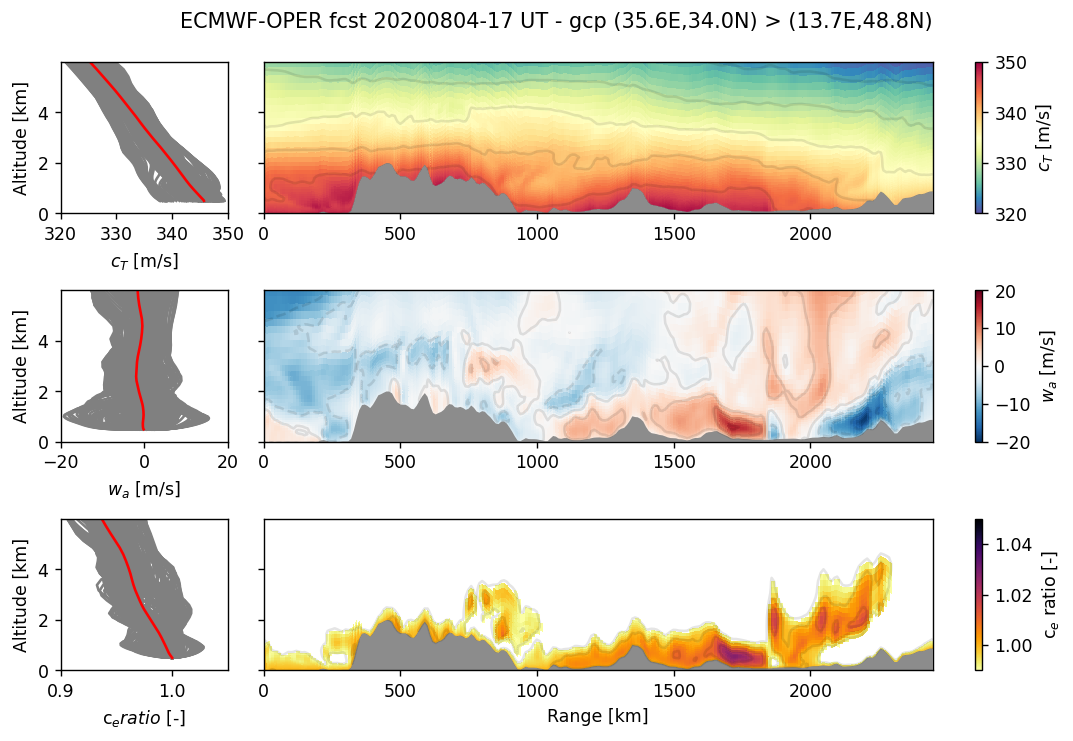

<ipython-input-20-c373515763d8>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0,1].pcolor(x, y, ds_gcp['cT'],
<ipython-input-20-c373515763d8>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1,1].pcolor(x, y, ds_gcp['wa'],
<ipython-input-20-c373515763d8>:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pa

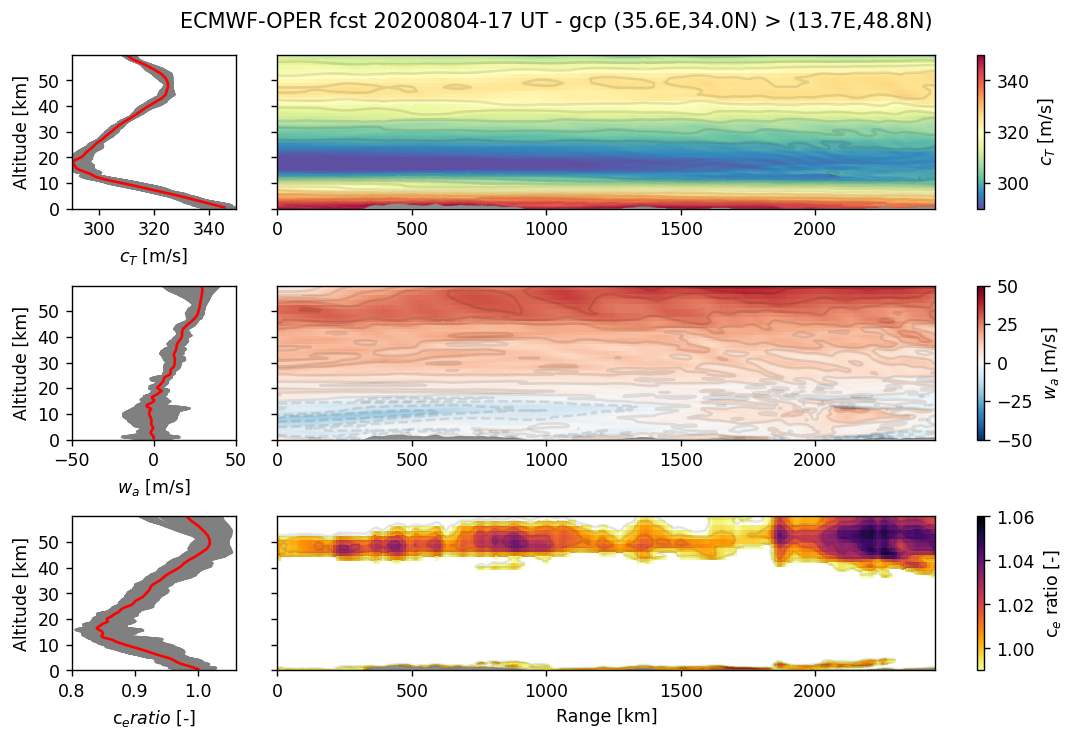

In [21]:
layers = dict()
layers['surface'] = dict(fid='surface', description='Near surface (0-6 km)',
                         z_min=0.0, z_max=6.0, dz=2.0)
layers['strato'] = dict(fid='strato', description='Troposphere - Stratosphere (0-60 km)',
                        z_min=0.0, z_max=60.0, dz=10)

for item in layers.keys():
    plot_infrasound_profile(my_atmos, ds_gcp, layers[item])

In [22]:
# from griblib.io.ascii import write_profile

# nr = ds_gcp.dims['distance']
# fid_summary = 'atmosphere_2d_summary.dat'
# line_fmt = '%9.3f %s'

# with open(fid_summary, "w") as summary: 
#     for ir in range(0,nr):
#         dspt =  ds_gcp.isel(distance=ir)
#         dspt['z'] -= float(dspt['z'].sel(hybrid=137))
#         distance = int(np.ceil(ds_gcp.isel(distance=ir).distance/1e3))
#         fid_profile = 'profiles/profile_{:04d}.dat'.format(distance)
#         summary.write('{} {}\n'.format(distance, fid_profile))
#         write_profile(dspt, fid_profile)

# summary.close()

In [23]:
# ds_gcp.to_netcdf('20200804-16-Beirut-I26DE.nc')

In [24]:
# ds_gcp